In [ ]:
!pip install PyAPD -U

In [1]:
# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

# At the time of gathering the data, the library had a different name
# to load the data, we associate the old name with the new
import sys
sys.modules['PyPolyCrystals'] = PyAPD

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)
#torch.set_default_device(device)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
# piece of code so that loading of data works on CPU only machines
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

#contents = pickle.load(f) becomes...
#contents = CPU_Unpickler(f).load()

In [8]:
#torch.load("optimal_apd_3D_sp.pkl",map_location=torch.device(device))

Number of seeds: tensor(50) tensor(100) tensor(250) tensor(500) tensor(1000) tensor(2500) tensor(5000) tensor(10000)
Number of pixels: tensor(48) tensor(50) tensor(52) tensor(54) tensor(56) tensor(64) tensor(66) tensor(68) tensor(70) tensor(88) tensor(90) tensor(92) tensor(94) tensor(110) tensor(112) tensor(114) tensor(116) tensor(118) tensor(120) tensor(140) tensor(144) tensor(146) tensor(148) tensor(150) tensor(198) tensor(200) tensor(202) tensor(250) tensor(252) tensor(254) tensor(316) tensor(318) tensor(320) tensor(322)
Box sizes: tensor(1.)
Anisotropies: tensor(0.) tensor(0.3000000000) tensor(0.7000000000)
Precisions: tensor([2])
Data points on each line: 8
Total number of data points: 240
Number of curves: 30
Number of 'unique' problems: 240


Text(0, 0.5, 'Time in seconds')

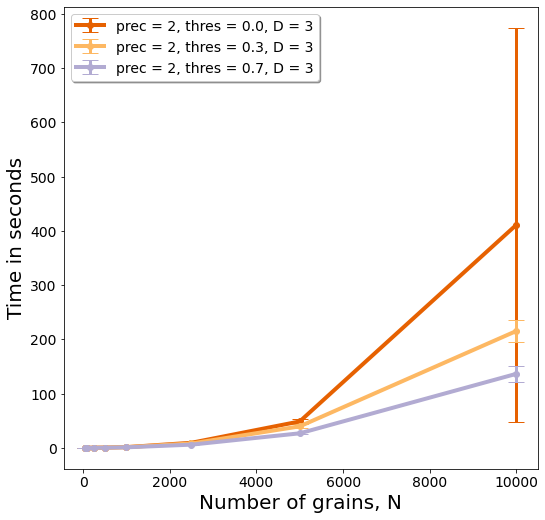

In [25]:
with open("optimal_apd_3D_mp.pkl", "rb") as fp: #Pickling
     #apd = pickle.load(fp)
    apd = CPU_Unpickler(fp).load()

def extract_data(apd,name):
    return torch.tensor([apd.data[i][name] for i in range(len(apd.data))])

                        
#Ns = torch.unique(torch.tensor([apd.data[i]["N"] for i in range(len(apd.data))]))


#torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))])

Ns = torch.unique(extract_data(apd,"N"))
print("Number of seeds:", *Ns)
Ms = torch.unique(extract_data(apd,"pixel_params"))
print("Number of pixels:", *Ms)
BSs = torch.unique(extract_data(apd,"box_size"))
print("Box sizes:", *BSs)
Anis = torch.unique(extract_data(apd,"ani_thres"))
print("Anisotropies:", *Anis)
DTs = torch.unique(torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))]))
print("Precisions:",DTs)
#DP = len(Ns)

DP = len(Ns)
print("Data points on each line:",DP)
L = len(apd.data)
print("Total number of data points:",L)

K = L//DP
print("Number of curves:",K)


P = len(DTs)
print("Number of 'unique' problems:",L//P)

#flat_timings = extract_data(apd,"apd_gen_time")
flat_timings = extract_data(apd,"time_to_find_W")
#flat_Ms = extract_data(apd,"pixel_params")[:,0]
flat_anis = extract_data(apd,"ani_thres")
flat_dts = torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))])
flat_seeds = extract_data(apd,"seed")
flat_Ds = extract_data(apd,"D")
#flat_anis
#flat_Ms[:,0]

timings = []
#errors = []
labels = []

flat_timings[0].item()

flat_anis.shape

flat_dts.shape

flat_labels = torch.stack([flat_anis,flat_dts,flat_seeds,flat_Ds],dim=1)

for k in range(K):
    #print(DP*k)
    #_timing = runtime_data[(DP*k):(DP*k+DP),7]
    _timing = flat_timings[DP*k:(DP*k+DP)]
#    _error = runtime_data[(DP*k):(DP*k+DP),6]
    _label = flat_labels[DP*k]
    #_weights = weights_data[(DP*k):(DP*k+DP)]
    #_gradients = Dgs[(DP*k):(DP*k+DP)]
    list.append(timings, _timing)
#    list.append(errors, _error)
    list.append(labels,_label)
    #list.append(weights,_weights)
    #list.append(gradients,_gradients)

timings_averaged = []
stds = []
kk = len(Anis)

for kkk in range(kk):
    list.append(timings_averaged,torch.mean(torch.stack(timings[kkk:-1:(kk)]),dim=0))
    list.append(stds,torch.std(torch.stack(timings[kkk:-1:(kk)]),dim=0))


colors = [(230/255,97/255,1/255),
(253/255,184/255,99/255),
(178/255,171/255,210/255),
(94/255,60/255,153/255)]

colors[0]

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8.5, 8.5, forward=True)
for i in range(len(timings_averaged)):
    ax1.errorbar(Ns, timings_averaged[i], yerr=stds[i], fmt='-o',
                 color = colors[i],
                 capsize=8, elinewidth=3,linewidth=4,
                 label = "prec = {}, thres = {}, D = {}".format(int(labels[i][1]),labels[i][0],int(labels[i][3])))
ax1.xaxis.label.set_size(20)
ax1.yaxis.label.set_size(20)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(14) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(14) 
    
    
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0),
            ncol=1, fancybox=True, shadow=True, fontsize="14")
ax1.set_xlabel("Number of grains, N")
ax1.set_ylabel("Time in seconds")
#ax1.set_yscale('log')
#ax1.set_xscale('log')

#fig.savefig('runtime_3d_mp_oapd.pdf')  

In [10]:
#timings[18][-1]

In [26]:
# ani, dt, seed, d
labels[0]

tensor([0., 2., 0., 3.])

In [27]:
data = copy.copy(apd.data)

In [28]:
d = data[239]
apd.__dict__ = {i:d[i] for i in d if i!='data'}

In [29]:
apd.device = 'cpu'

In [30]:
apd.pixel_params

(320, 320, 320)

In [31]:
# lazy tensor assembly:
apd.set_X(apd.X)
apd.set_As(apd.As)
apd.set_W(apd.W)
apd.assemble_pixels()

In [32]:
img = apd.assemble_apd()

In [33]:
img2 = img.numpy()
img2
;

''

In [35]:
pl = pv.Plotter(window_size=[4*840, 4*640])
pl.add_volume(img2,opacity=1.0)
pl.remove_scalar_bar()
pl.add_bounding_box(line_width=5, color='black')
pl.set_background('white')
#cpos = pl.camera_position
#pl.camera_position = cpos
pl.show()
pl.save_graphic(f'example_3d_mp_oapd.pdf')

Widget(value="<iframe src='http://localhost:35095/index.html?ui=P_0x7fda18011850_10&reconnect=auto' style='wid…